#### Coordinate System is [EPSG:3857](https://epsg.io/3857) WGS 84 / Pseudo-Mercator -- Spherical Mercator, used by Google Maps, OpenStreetMap, Bing, ArcGIS, ESRI 

We need to transform WGS84 coordinates [EPSG:4326](https://epsg.io/4326) to [EPSG:3857](https://epsg.io/3857) by using the get_lat_lng_tile(lat, lng, zoom) method

##### Observe that get_tile_box(zoom, x, y) returns a square whose upper left corner is the original point.

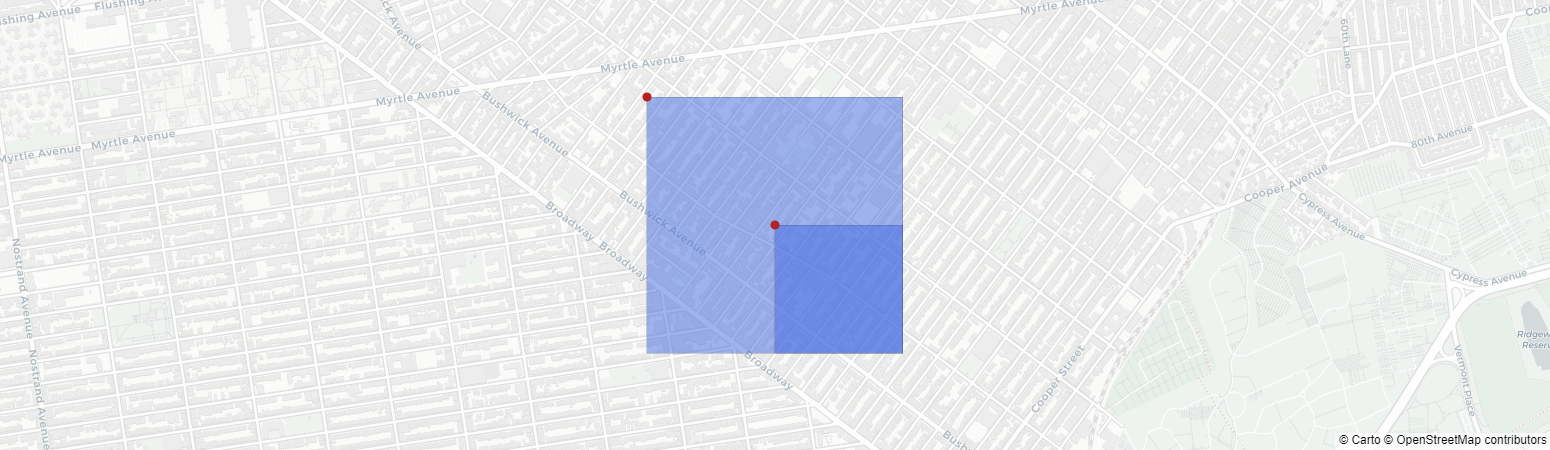

Loading the methods from: https://github.com/hrldcpr/mercator.py/blob/master/mercator.py

In [2]:
import math

def get_tile_box(zoom, x, y):
    """convert Google-style Mercator tile coordinate to
    (minlat, maxlat, minlng, maxlng) bounding box"""

    minlat, minlng = get_tile_lat_lng(zoom, x, y + 1)
    maxlat, maxlng = get_tile_lat_lng(zoom, x + 1, y)

    return (minlat, maxlat, minlng, maxlng)

def get_tile_lat_lng(zoom, x, y):
    """convert Google-style Mercator tile coordinate to
    (lat, lng) of top-left corner of tile"""

    # "map-centric" latitude, in radians:
    lat_rad = math.pi - 2*math.pi*y/(2**zoom)
    # true latitude:
    lat_rad = gudermannian(lat_rad)
    lat = lat_rad * 180.0 / math.pi

    # longitude maps linearly to map, so we simply scale:
    lng = -180.0 + 360.0*x/(2**zoom)

    return (lat, lng)

def get_lat_lng_tile(lat, lng, zoom):
    """convert lat/lng to Google-style Mercator tile coordinate (x, y)
    at the given zoom level"""

    lat_rad = lat * math.pi / 180.0
    # "map-centric" latitude, in radians:
    lat_rad = inv_gudermannian(lat_rad)

    x = 2**zoom * (lng + 180.0) / 360.0
    y = 2**zoom * (math.pi - lat_rad) / (2 * math.pi)

    return (x, y)

def gudermannian(x):
    return 2*math.atan(math.exp(x)) - math.pi/2

def inv_gudermannian(y):
    return math.log(math.tan((y + math.pi/2) / 2))

In [3]:
import plotly.graph_objects as go
import plotly.figure_factory as ff


# 1. Define zoom level and starting point
zoom_level = 15
lng, lat = -73.9249, 40.6970

# 2. Transform WGS84 coordinates to Mercator
lat_t, lng_t = get_lat_lng_tile(lat, lng, zoom_level)
print(lng_t, lat_t)

# 3. Get bounding box coordinates in WGS84
minlat, maxlat, minlng, maxlng = get_tile_box(zoom_level, lat_t, lng_t)
print(minlat, maxlat, minlng, maxlng)

# 4. Get center pont of boinging box and repeat 
lat_1, lng_1 = (minlat + maxlat) / 2, (minlng + maxlng) / 2

lat_t_1, lng_t_1 = get_lat_lng_tile(lat_1, lng_1, zoom_level + 1)
print(lng_t_1, lat_t_1)

minlat_1, maxlat_1, minlng_1, maxlng_1 = get_tile_box(
    zoom_level + 1, lat_t_1, lng_t_1)
print(minlat_1, maxlat_1, minlng_1, maxlng_1)

# 5. Plot results

fig = go.Figure(go.Scattermapbox(
    mode="markers",
    lon=[lng, lng_1], lat=[lat, lat_1],
    marker={'size': 10, 'color': ['#B42222', '#B42222']}))

fig.update_layout(
    mapbox={
        'style': "carto-positron",
        'center': {"lat": (minlat + maxlat) / 2, "lon": (minlng + maxlng) / 2},
        'zoom': zoom_level - 1, 
        'layers': [{
            'source': {
                'type': "FeatureCollection",
                'features': [
                    {
                        'type': "Feature",
                        'geometry': {
                            'type': "MultiPolygon",
                            'coordinates': [[
                                [
                                    [minlng, minlat], [maxlng, minlat],
                                    [maxlng, maxlat], [minlng, maxlat]
                                ]
                            ]]
                        }
                    },
                    {
                        'type': "Feature",
                        'geometry': {
                            'type': "MultiPolygon",
                            'coordinates': [[
                                [
                                    [minlng_1, minlat_1], [maxlng_1, minlat_1],
                                    [maxlng_1, maxlat_1], [minlng_1, maxlat_1]
                                ]
                            ]]
                        }
                    }
                ]
            },
            'type': "fill", 'below': "traces", 'color': "royalblue", "opacity": 0.5}]},
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0})

fig.show()

12322.03589768292 9655.191324444446
40.68866999160308 40.69700000000001 -73.92489999999998 -73.91391367187498
24645.071826620868 19311.38264888889
40.6886698614176 40.69283499580154 -73.91940683593748 -73.91391367187498


### Can we do this for atlanta?

In [4]:
import json
import osmnx as ox
import geopandas as gpd
import numpy as np

place_name = "Atlanta, Georgia"
tags = {"name": "Atlanta"}
atlanta_boundary = ox.features_from_place(place_name, tags)

city_boundary = atlanta_boundary.geometry[atlanta_boundary.geometry.type == "MultiPolygon"]

lng = np.mean(city_boundary.geometry.bounds.maxx +
              city_boundary.geometry.bounds.minx)/2
lat = np.mean(city_boundary.geometry.bounds.maxy +
              city_boundary.geometry.bounds.miny)/2

zoom_level = 10
lat_t, lng_t = get_lat_lng_tile(lat, lng, zoom_level)

minlat, maxlat, minlng, maxlng = get_tile_box(zoom_level, lat_t - 0.5, lng_t - 0.5)

start_lat = maxlat
start_lng = minlng


fig = go.Figure(go.Scattermapbox(
    mode="markers",
    lon=[lng, start_lng], lat=[lat, start_lat],
    marker={'size': 10, 
            'color': ['#B42222', '#B42222']}))

fig.update_layout(
    mapbox={
        'style': "carto-positron",
        'center': {"lat": lat, "lon": lng},
        'zoom': zoom_level - 1,
        'layers': [
            {
                'source': json.loads(atlanta_boundary.geometry.to_json()),
                'type': "fill", 'below': "traces", 'color': "royalblue", "opacity": 0.5
            },
            {
                'source': {
                    'type': "FeatureCollection",
                    'features': [
                        {
                            'type': "Feature",
                            'geometry': {
                                'type': "MultiPolygon",
                                'coordinates': [[
                                    [
                                        [minlng, minlat], [maxlng, minlat],
                                        [maxlng, maxlat], [minlng, maxlat], [minlng, minlat]
                                    ]
                                ]]
                            }
                        }
                    ]
                },
                'type': "fill", 'below': "traces", 'color': "royalblue", "opacity": 0.5
            }
        ]
    },
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0})

fig.show()

In [5]:
import geopandas as gpd
from shapely.geometry import Polygon

zoom_level_grid = 15
start_lat_t, start_lng_t = get_lat_lng_tile(
    start_lat, start_lng, zoom_level_grid)

grid_size = int(2**(zoom_level_grid) / 2**(zoom_level))

lat_ij, lng_ij = start_lat_t - 1, start_lng_t - 1

cells = []
polygons = []

for i in range(grid_size):
    lat_ij += 1
    for j in range(grid_size):
        lng_ij += 1

        minlat_ij, maxlat_ij, minlng_ij, maxlng_ij = get_tile_box(
            zoom_level_grid, lat_ij, lng_ij)

        coords = [
            [minlng_ij, minlat_ij],
            [maxlng_ij, minlat_ij],
            [maxlng_ij, maxlat_ij],
            [minlng_ij, maxlat_ij],
            [minlng_ij, minlat_ij]
        ]

        polygon = Polygon(coords)

        polygons.append(polygon)

        cell = {
            'source': {
                'type': "FeatureCollection",
                'features': [
                        {
                            'type': "Feature",
                            'geometry': {
                                'type': "MultiPolygon",
                                'coordinates': [[coords
                                ]]
                            }
                        }
                ]
            },
            'type': "fill", 'below': "traces", 'color': "orange", "opacity": 0.25
        }

        cells.append(cell)

    lng_ij -= (grid_size)

grid_gdf = gpd.GeoDataFrame(crs='epsg:4326', geometry=polygons)

<Axes: >

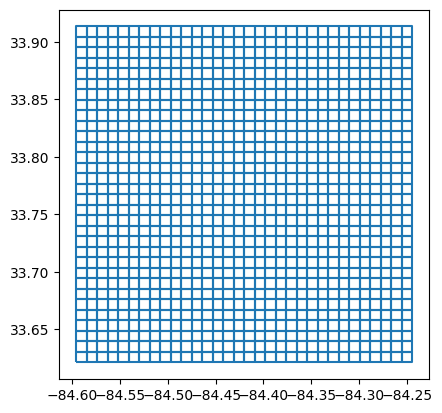

In [12]:
grid_gdf.to_file('map_tiling_Atlanta_zoom_15.geojson', driver='GeoJSON')  
grid_gdf.geometry.boundary.plot()

In [8]:
cells[0]

{'source': {'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'geometry': {'type': 'MultiPolygon',
     'coordinates': [[[[-84.59609524999999, 33.90875926587176],
        [-84.59060208593749, 33.90875926587176],
        [-84.59060208593749, 33.91331806916853],
        [-84.59609524999999, 33.91331806916853],
        [-84.59609524999999, 33.90875926587176]]]]}}]},
 'type': 'fill',
 'below': 'traces',
 'color': 'orange',
 'opacity': 0.25}

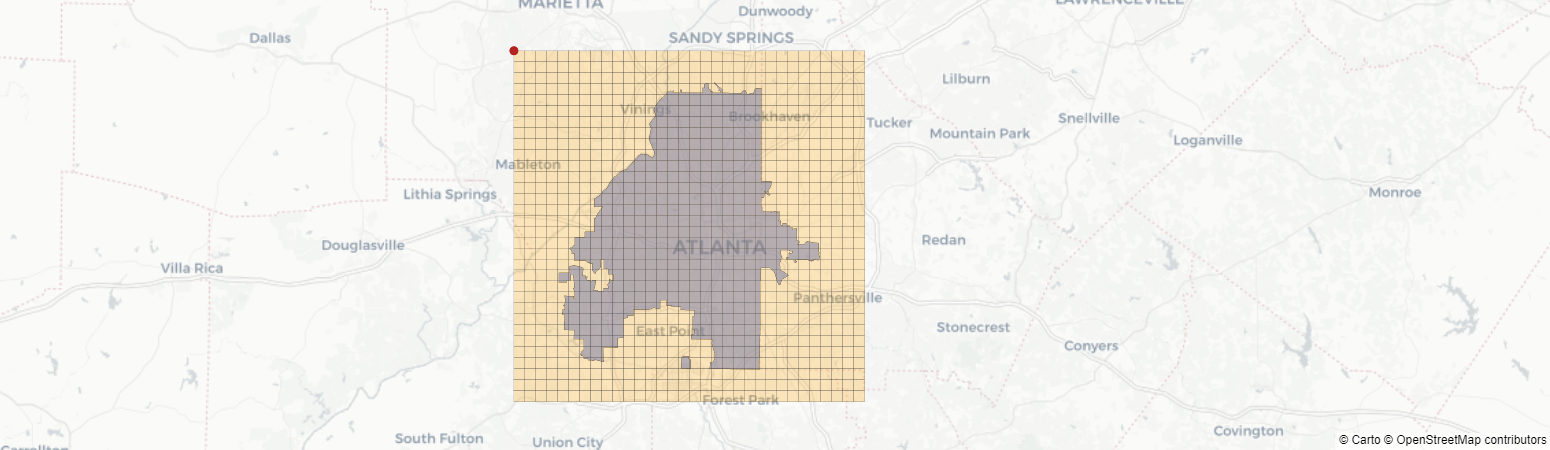

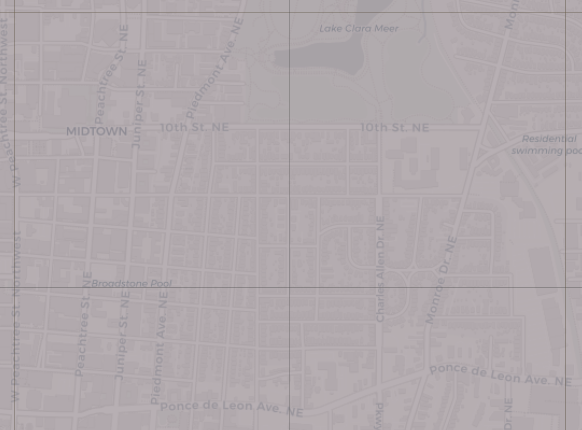

In [11]:
# layers = []
# layers.append(    {
#         'source': json.loads(atlanta_boundary.geometry.to_json()),
#         'type': "fill", 'below': "traces", 'color': "royalblue", "opacity": 0.5
#     })


# layers += cells

# fig = go.Figure(go.Scattermapbox(
#     mode="markers",
#     lon=[start_lng], lat=[start_lat],
#     marker={'size': 10,
#             'color': ['#B42222', '#B42222']}))

# fig.update_layout(
#     mapbox={
#         'style': "carto-positron",
#         'center': {"lat": lat, "lon": lng},
#         'zoom': zoom_level - 1,
#         'layers': layers
#     },
#     margin={'l': 0, 'r': 0, 'b': 0, 't': 0})

# fig.show()